In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
from matplotlib import pyplot as plt
import multigrate as mtg
import gdown

# Load the dataset

In [2]:
# download data if needed from https://drive.google.com/drive/folders/1vdO8CJluRp7sOOQHc85YYZXhV2p2QcDN
# gdown.download(
#    'https://drive.google.com/uc?id=1QK5Ua4HStjIm3URxw4WHHM2gdzDmbvsN',
#    '../data/10xpbmc10k-2020/expressions_hvg.h5ad'
#)

In [3]:
# gdown.download(
#    'https://drive.google.com/uc?id=1OkryKwFCna0hWD_oUiRFknzVy72oaFfc',
#    '../data/10xpbmc10k-2020/peaks.h5ad'
#)

In [4]:
scrna = sc.read_h5ad('../data/10xpbmc10k-2020/expressions_hvg.h5ad')
scrna

AnnData object with n_obs × n_vars = 10000 × 4000
    obs: 'cell_type'
    layers: 'count'

In [5]:
scatac = sc.read_h5ad('../data/10xpbmc10k-2020/peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'cell_type'
    layers: 'binary'

# Configure and train the model

Currently, there are two models you can choose from: MultiVAE_PoE_small or MultiVAE_PoE_cond. There are only small differences in the architecture, and the result should not differ that much.

To configure the model, we need to specify the following parameters:
   - pair_groups = whether the data is paired or not; if the data is paired same number should be passed, e.g. [[0], [0]] or [[1], [1]], if not paired then different numbers, e.g. [[0], [1]]
   - condition = whether the model is a cVAE. Set to True if integration multiple datasets or using query to reference mapping
   - z_dim = number of dimentions in the latent space
   - h_dim = number of dimentions in the hidden space, i.e. output dimention of the modality encoders and input dimention of the shared encoder
   - hiddens = dimentionality of hidden layers in modality encoders/decoders; e.g. if hiddens = [[512], [1024]] then the input dimentions of modality encoders would be 3999 -> 512 -> 128 for rna and 40018 -> 1024 -> 128 for atac
   - losses = loss per modality. Has to be one of ['mse', 'nb', 'zinb', 'bce']. We recomend using 'nb' with raw gene counts or 'mse' with normalized gene expressions, 'mse' with normalized protein data and 'bce' with binarized peaks or 'mse' with mormalized peaks
   - layers = which layer in AnnData onject to use. Default is to use .X but if layer is specified per modality, use that one.
   - output_actiations = activation funtions of the last layer of modelity decoders; has to be one of ['linear', 'relu', 'leakyrelu', 'sigmoid']
   - shared_hiddens = dimentionality of hidden layers in the shared encoder/decoder; e.g. if shared_hiddens = [64], then the input dimentions of the shared encoder would be 128 -> 64 -> 20
   - recon_coef = reconstruction coefficient, i.e. the weight of MSE reconstruction loss in the total loss (the higher the more important)
   - kl_coef = KL-divergence loss coefficient
   - cycle_coef = cycle consistency loss coefficient
   
Additionally, adatas, names, pair_groups and hiddens should have the same number of modalities and the same length per modality.

In [6]:
model = mtg.models.MultiVAE_PoE_cond( # or change to MultiVAE_PoE_small
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    pair_groups=[[0], [0]],
    condition=False, # set to True if integrating multiple datasets
    z_dim=20,
    h_dim=32, # only needs to be set in MultiVAE_PoE_cond
    hiddens=[[], []],
    output_activations=['linear', 'linear'], # will be changed internally to softmax for NB loss
    losses=['nb', 'mse'], # recommend using NB for RNA modality, MSE for ATAC and ADT
    layers=[['count'], [None]], # specify layers if needed, if not specified uses .X
    recon_coef=1,
    cycle_coef=0, # testing now, leave always 0 for now
    kl_coef=1e-6, # usually somewhere between 1e-5 and 1e-7 works well
    integ_coef=1e-2, # don't need here as just one dataset, usually try out from 1e-2 to 1
    dropout=0.2,
)

In [7]:
model.train(
    n_iters=10000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    kl_anneal_iters=5000,
    validate_every=1000
)

 |████████████████████| 100.0% iter=10000/10000, time=19.73(s), loss=0.4434, recon=0.4433, kl=145.0991, integ=0.0000, cycle=0.0000, val_loss=0.4289, val_recon=0.4287, val_kl=138.7181, val_integ=0.0000, val_cycle=0.0000

## Plot training history

In [8]:
model.history

,iteration,train_loss,train_recon,train_recon_mse,train_recon_nb,train_recon_zinb,train_recon_bce,train_kl,train_integ,train_cycle,mod_vec0_norm,cos_similarity_mod_vectors_0_1,mod_vec1_norm,val_loss,val_recon,val_recon_mse,val_recon_nb,val_kl,val_integ,val_cycle
0,1000,0.573485,0.573476,0.120726,0.452750,0.0,0.0,71.615553,0.0,0.0,4.857159,-0.23172,5.473633,0.487225,0.487209,0.103955,0.383254,79.206070,0,0
1,2000,0.467338,0.467312,0.101880,0.365431,0.0,0.0,81.899409,0.0,0.0,4.857159,-0.23172,5.473633,0.454599,0.454565,0.101021,0.353544,85.612282,0,0
2,3000,0.466637,0.466587,0.102479,0.364108,0.0,0.0,95.649472,0.0,0.0,4.857159,-0.23172,5.473633,0.446036,0.445979,0.100587,0.345391,94.447166,0,0
3,4000,0.449989,0.449911,0.099311,0.350600,0.0,0.0,109.172421,0.0,0.0,4.857159,-0.23172,5.473633,0.441727,0.441643,0.100413,0.341230,103.889946,0,0
4,5000,0.447178,0.447071,0.098518,0.348554,0.0,0.0,115.862860,0.0,0.0,4.857159,-0.23172,5.473633,0.437628,0.437517,0.100155,0.337362,110.664696,0,0
5,6000,0.451372,0.451248,0.099798,0.351450,0.0,0.0,124.558342,0.0,0.0,4.857159,-0.23172,5.473633,0.434758,0.434640,0.100068,0.334572,117.956726,0,0
6,7000,0.432818,0.432689,0.099075,0.333614,0.0,0.0,128.787210,0.0,0.0,4.857159,-0.23172,5.473633,0.432709,0.432581,0.100015,0.332566,127.564125,0,0
7,8000,0.447124,0.446988,0.101246,0.345742,0.0,0.0,135.938708,0.0,0.0,4.857159,-0.23172,5.473633,0.431426,0.431295,0.099981,0.331314,131.432968,0,0
8,9000,0.433647,0.433506,0.100534,0.332972,0.0,0.0,141.780811,0.0,0.0,4.857159,-0.23172,5.473633,0.430128,0.429995,0.099906,0.330089,133.418839,0,0
9,9999,0.443408,0.443263,0.100064,0.343199,0.0,0.0,145.099081,0.0,0.0,4.857159,-0.23172,5.473633,0.428872,0.428733,0.099827,0.328906,138.718124,0,0


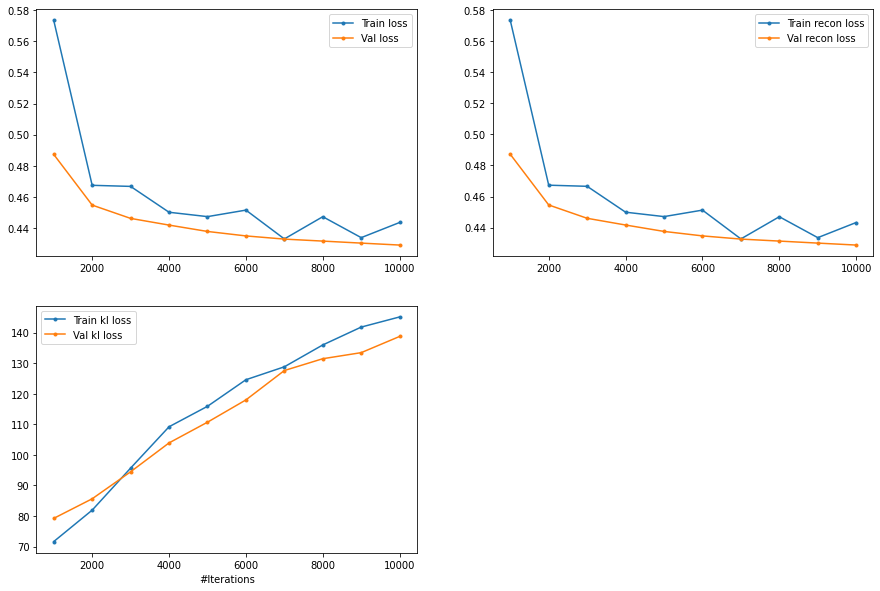

In [9]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

# Validation

### UMAP plot of the latent space

In [10]:
out = model.test(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    layers=[['count'], [None]],
    pair_groups=[[0], [0]], # just need to be the same
    batch_size=64,
)

In [11]:
z, _, _, _ = out

In [12]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'modality' as categorical
... storing 'cell_type' as categorical


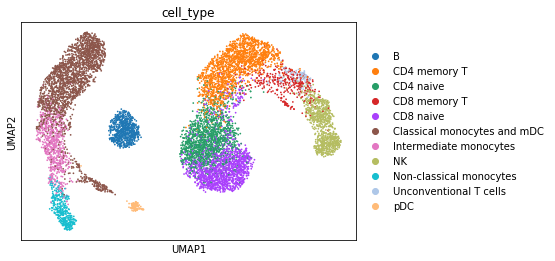

In [13]:
sc.pl.umap(z, color=['cell_type'])